# Automated Identification of Amblyomma Tick Species Using Convolutional Neural Networks
## Name:Gayathry siva
## Roll no:CB.AI.P2DSC25011
### Course: Deep Learning  
### Assignment1  
### Models Used: AlexNet, ResNet-50, MobileNetV2


## Objective

The objective of this project is to automatically classify six species of Amblyomma ticks using convolutional neural network (CNN) architectures. The performance of three different models—AlexNet, ResNet-50, and MobileNetV2—is evaluated and compared using a common dataset.


## Dataset Description

The dataset consists of tick images belonging to six different Amblyomma species.  
Each species is stored in a separate folder, and images are used for supervised learning.  
The dataset is sourced from the reference paper on automated tick identification.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Automated identification of spotted-fever tick vectors using convolutional neural networks/7-All images combined"


## Dataset Details
The dataset consists of images of tick specimens from the *Amblyomma* genus. Images are organized into class-specific folders corresponding to different species.  

The original dataset contains six classes:
- Amblyomma aureolatum  
- Amblyomma cajennense  
- Amblyomma dubitatum  
- Amblyomma ovale  
- Amblyomma sculptum  
- Amblyomma triste  

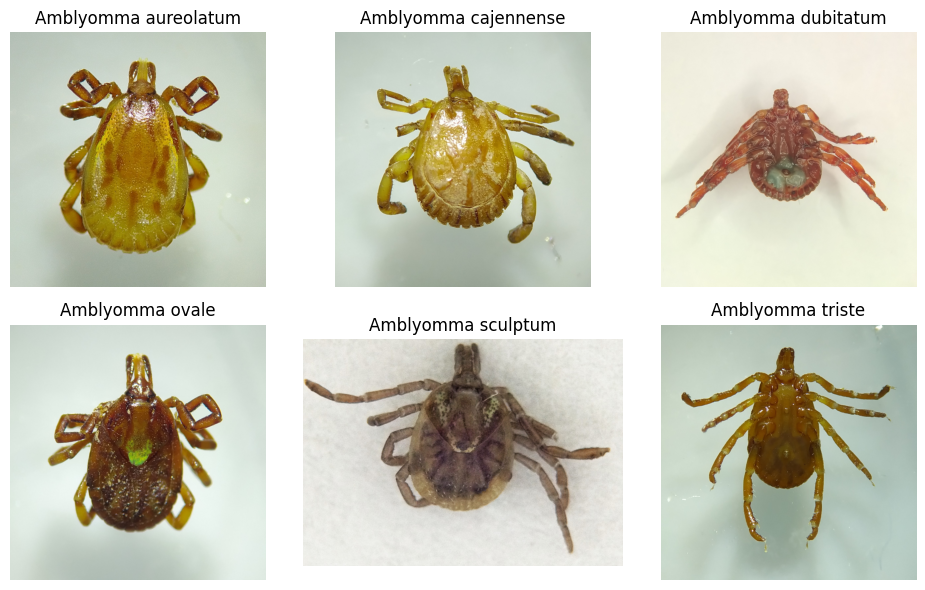

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

data_dir = "/content/drive/MyDrive/Automated identification of spotted-fever tick vectors using convolutional neural networks/7-All images combined"

class_names = sorted([
    d for d in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, d))
])

plt.figure(figsize=(10, 6))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)

    # Select a random image from the class folder
    image_name = random.choice([
        f for f in os.listdir(class_path)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ])

    image_path = os.path.join(class_path, image_name)
    img = Image.open(image_path)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Data Pre-processing and Augmentation

* To prepare the tick dataset for the CNN models, we implement several pre-processing and augmentation steps.These steps ensure the models are robust to variations in how images are captured.

**Key Steps Included:**
* Image Resizing: All images are resized to 224x224 pixels (for ResNet-50/MobileNetV2) or 227x227 (for AlexNet) to match the required input size of the pre-trained architectures.
* Data Augmentation: To improve generalization and prevent overfitting on our small dataset, we apply:
1. Random Rotation ($\pm20^\circ$): Accounts for ticks being photographed at different angles.
2. Random Affine (Translation & Scaling): Simulates different distances from the camera and off-center subjects.
3. Horizontal Flipping: Mimics "mirror" views of the specimens to increase variety.

* Normalization: We scale pixel values using the ImageNet mean and standard deviation. This centers the data and helps the model converge faster during training.
* Tensor Conversion: Images are converted into PyTorch Tensors to be processed by the GPU.





In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 1. Define the Pre-processing & Augmentation (As per the paper)
# Resizing to 224x224 for ResNet-50 and MobileNetV2
img_size = 224

data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomRotation(degrees=20),             # ±20 degrees rotation
    transforms.RandomAffine(
        degrees=0,
        translate=(5/img_size, 5/img_size),            # ±5 pixels translation
        scale=(0.8, 1.2)                                # 80% to 120% scaling
    ),
    transforms.RandomHorizontalFlip(p=0.5),            # Reflection (Horizontal flip)
    transforms.ToTensor(),                             # Convert to Tensor
    transforms.Normalize(                              # Standard ImageNet Normalization
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# 2. Load the Dataset from Drive path
try:
    full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    print(f"Successfully loaded dataset!")
    print(f"Total images: {len(full_dataset)}")
    print(f"Classes (Species) detected: {full_dataset.classes}")
except Exception as e:
    print(f"Error: Ensure the path is correct. Current path: {data_dir}")
    print(e)

Successfully loaded dataset!
Total images: 825
Classes (Species) detected: ['Amblyomma aureolatum', 'Amblyomma cajennense', 'Amblyomma dubitatum', 'Amblyomma ovale', 'Amblyomma sculptum', 'Amblyomma triste']


## ResNet-50(Residual Network)
ResNet-50 is a 50-layer deep network that revolutionized deep learning through the introduction of Residual Blocks.

**Key Feature:**
It uses Skip Connections (Identity Shortcuts) that allow the gradient to bypass one or more layers. This effectively solves the "vanishing gradient" problem found in very deep networks.

**Structure:** It consists of one 7x7 convolution, followed by multiple "Bottleneck" blocks (1x1, 3x3, and 1x1 convolutions), and ends with a Fully Connected (FC) layer adjusted to 6 classes.
ResNet-50 is a 50-layer deep network that revolutionized deep learning through the introduction of Residual Blocks.


ResNet-50 Block Flow: Input (224x224x3) --> Conv(7x7) --> MaxPool --> [Residual Bottleneck Blocks] x16 --> GlobalAvgPool --> FC(6) --> Output

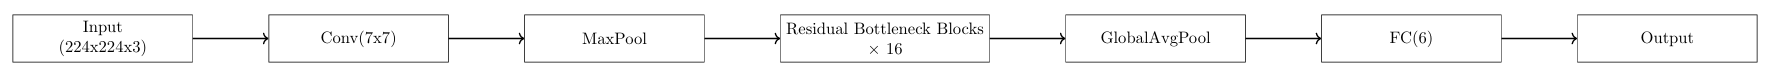

In [12]:
from IPython.display import Image, display

display(Image(filename="/content/ResNet.png", width=1500))


In [ ]:
import torch.nn as nn
from torchvision import models

def get_resnet50(num_classes):
    # We use weights='IMAGENET1K_V1' to match the "pre-trained" status in the paper
    model = models.resnet50(weights='IMAGENET1K_V1')

    # Replace the final fully connected layer to match our 6 classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

# Initialize
num_classes = len(full_dataset.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model = get_resnet50(num_classes).to(device)

print(f"ResNet-50 model initialized on {device}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


ResNet-50 model initialized on cuda


In [ ]:
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001
K_FOLDS = 5

kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_results = []


train_idx, val_idx = list(kf.split(full_dataset))[0]

train_sub = Subset(full_dataset, train_idx)
val_sub = Subset(full_dataset, val_idx)

train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

# Optimizer: Adam
optimizer = optim.Adam(resnet_model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

print("Starting ResNet-50 Training...")

for epoch in range(EPOCHS):
    resnet_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}")

# Performance Evaluation
resnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nResNet-50 Accuracy on Validation Set: {100 * correct / total:.2f}%")

Starting ResNet-50 Training...
Epoch 5/50 - Loss: 0.3260
Epoch 10/50 - Loss: 0.1435
Epoch 15/50 - Loss: 0.1410
Epoch 20/50 - Loss: 0.1984
Epoch 25/50 - Loss: 0.1310
Epoch 30/50 - Loss: 0.1222
Epoch 35/50 - Loss: 0.1167
Epoch 40/50 - Loss: 0.0857
Epoch 45/50 - Loss: 0.1130
Epoch 50/50 - Loss: 0.0413

ResNet-50 Accuracy on Validation Set: 93.94%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, loader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define species names based on dataset folders
    class_names = loader.dataset.dataset.classes

    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_labels, all_preds, class_names


y_true, y_pred, species_labels = evaluate_model(resnet_model, val_loader, device, "ResNet-50")


--- ResNet-50 Classification Report ---
                      precision    recall  f1-score   support

Amblyomma aureolatum       0.96      0.83      0.89        30
Amblyomma cajennense       0.96      1.00      0.98        24
 Amblyomma dubitatum       0.95      0.81      0.88        26
     Amblyomma ovale       0.89      1.00      0.94        24
  Amblyomma sculptum       0.93      1.00      0.96        25
    Amblyomma triste       0.95      1.00      0.97        36

            accuracy                           0.94       165
           macro avg       0.94      0.94      0.94       165
        weighted avg       0.94      0.94      0.94       165



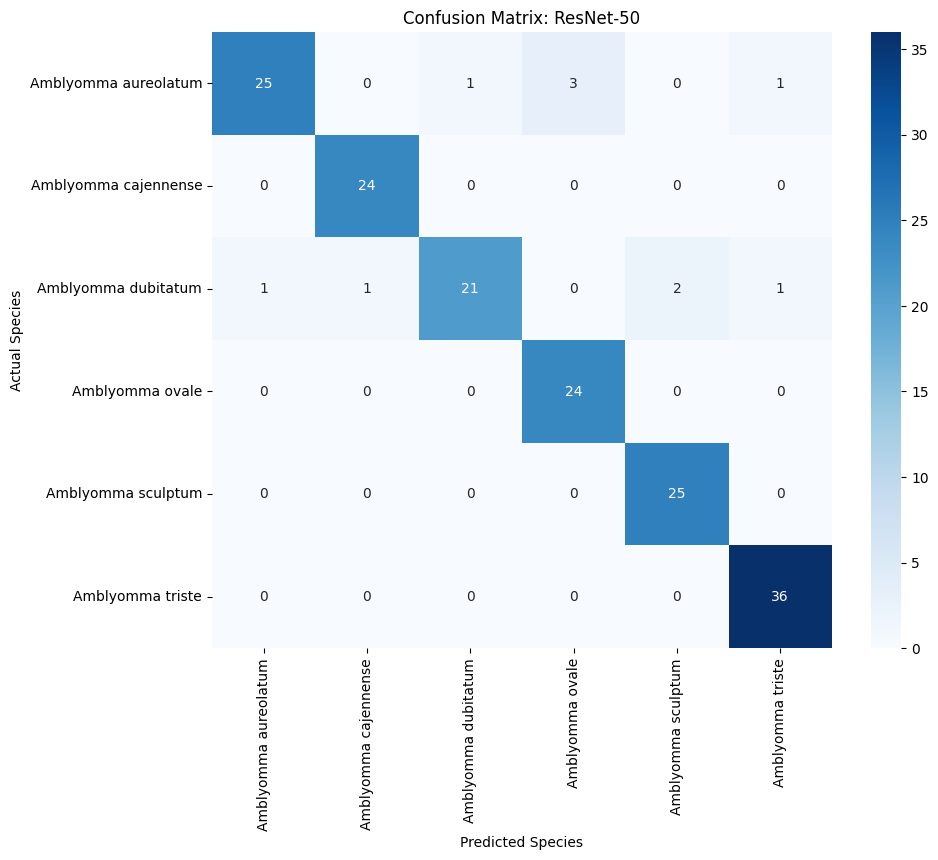

In [ ]:
def plot_cm(y_true, y_pred, class_names, model_title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_title}')
    plt.ylabel('Actual Species')
    plt.xlabel('Predicted Species')
    plt.show()

plot_cm(y_true, y_pred, species_labels, "ResNet-50")

## AlexNet
AlexNet was the winner of the 2012 ImageNet challenge and is a foundational "classic" CNN.

**Key Feature:** It utilizes a deep architecture with 8 layers (5 Convolutional and 3 Fully Connected). It was the first to use ReLU (Rectified Linear Units) for faster training and Dropout to prevent overfitting.

**Structure:** It uses larger filters (11x11 and 5x5) in its initial layers to capture broad morphological features of the tick specimens. For this project, the final layer was modified to match our 6 species.



AlexNet Block Flow: Input (227x227x3) --> Conv(11x11) --> MaxPool --> Conv(5x5) --> MaxPool --> [Conv(3x3)]x3 --> MaxPool --> FC(4096)x2 --> FC(6) --> Output

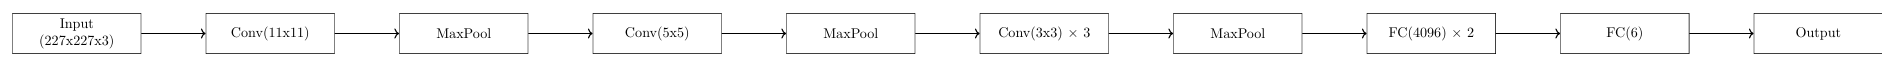

In [13]:
from IPython.display import Image, display

display(Image(filename="/content/AlexNet.png", width=1500))


In [ ]:
# AlexNet specific transformations (227x227)
alexnet_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(5/227, 5/227), scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the AlexNet dataset
alex_dataset = datasets.ImageFolder(root=data_dir, transform=alexnet_transforms)

In [ ]:
def get_alexnet(num_classes):
    model = models.alexnet(weights='IMAGENET1K_V1')
    # The final layer is model.classifier[6]
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

alex_model = get_alexnet(num_classes=6).to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:01<00:00, 152MB/s]


In [ ]:
# Parameters
optimizer_alex = optim.SGD(alex_model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print("Starting AlexNet Training with SGDM...")

# For continuity, use the same first fold as before
train_sub_alex = Subset(alex_dataset, train_idx)
val_sub_alex = Subset(alex_dataset, val_idx)

train_loader_alex = DataLoader(train_sub_alex, batch_size=64, shuffle=True)
val_loader_alex = DataLoader(val_sub_alex, batch_size=64, shuffle=False)

for epoch in range(50):
    alex_model.train()
    for inputs, labels in train_loader_alex:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_alex.zero_grad()
        outputs = alex_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_alex.step()

    if (epoch + 1) % 10 == 0:
        print(f"AlexNet Epoch {epoch+1}/50 complete.")

# Performance Evaluation
alex_model.eval()

Starting AlexNet Training with SGDM...
AlexNet Epoch 10/50 complete.
AlexNet Epoch 20/50 complete.
AlexNet Epoch 30/50 complete.
AlexNet Epoch 40/50 complete.
AlexNet Epoch 50/50 complete.


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# Performance Evaluation
alex_model.eval()

correct = 0
total = 0

# No gradients needed for evaluation
with torch.no_grad():
    for inputs, labels in val_loader_alex:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = alex_model(inputs)

        # Get the index of the highest score (the prediction)
        _, predicted = torch.max(outputs.data, 1)

        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"AlexNet Accuracy on Validation Set: {accuracy:.2f}%")

AlexNet Accuracy on Validation Set: 93.33%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, loader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define species names based on dataset folders
    class_names = loader.dataset.dataset.classes

    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_labels, all_preds, class_names


y_true, y_pred, species_labels = evaluate_model(alex_model, val_loader, device, "AlexNet")


--- AlexNet Classification Report ---
                      precision    recall  f1-score   support

Amblyomma aureolatum       0.81      0.97      0.88        30
Amblyomma cajennense       1.00      0.88      0.93        24
 Amblyomma dubitatum       1.00      0.81      0.89        26
     Amblyomma ovale       0.92      0.96      0.94        24
  Amblyomma sculptum       1.00      0.96      0.98        25
    Amblyomma triste       0.95      1.00      0.97        36

            accuracy                           0.93       165
           macro avg       0.95      0.93      0.93       165
        weighted avg       0.94      0.93      0.93       165



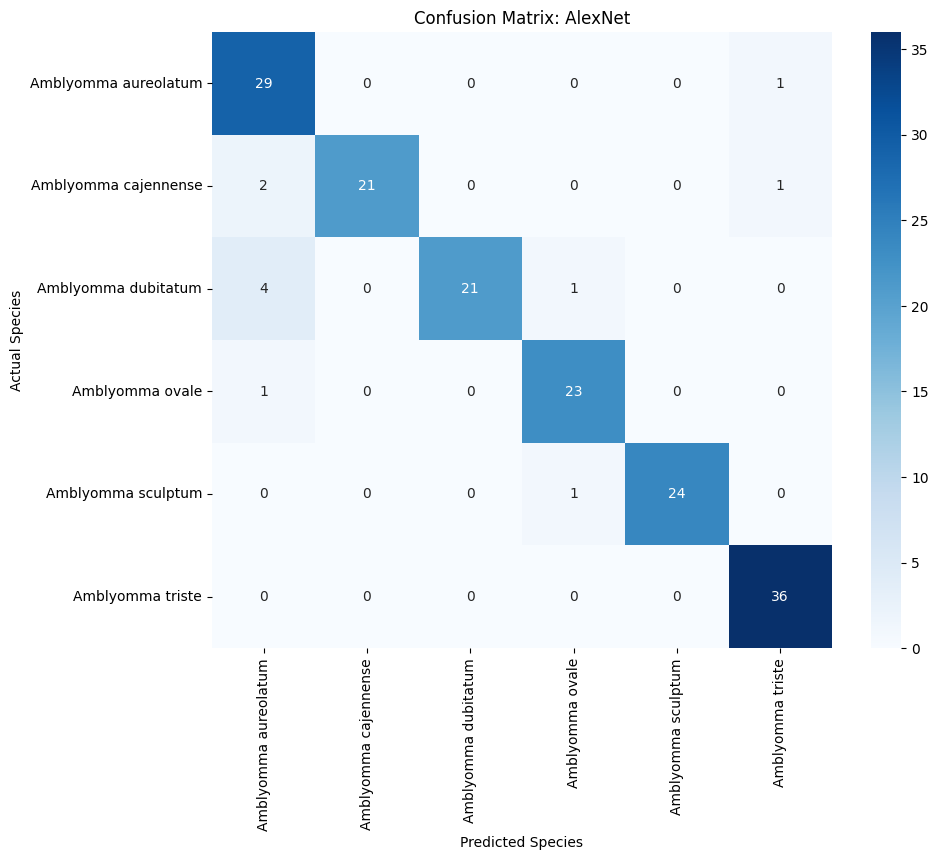

In [ ]:
def plot_cm(y_true, y_pred, class_names, model_title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_title}')
    plt.ylabel('Actual Species')
    plt.xlabel('Predicted Species')
    plt.show()

plot_cm(y_true, y_pred, species_labels, "AlexNet")

## MobileNetV2
MobileNetV2 is an efficient, lightweight model designed specifically for mobile and resource-constrained environments.

**Key Feature:** It introduces Inverted Residual Blocks and Depthwise Separable Convolutions. This significantly reduces the number of parameters and computational cost without a major loss in accuracy.

**Structure:** It follows a narrow-wide-narrow approach—expanding the data into higher dimensions to learn complex features and then compressing it back down. This makes it ideal for a real-time smartphone application for field researchers.



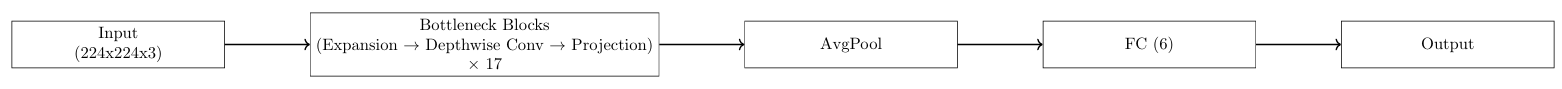

In [14]:
from IPython.display import Image, display

display(Image(filename="/content/MobileNet.png", width=1500))


In [ ]:
import torch.nn as nn
from torchvision import models
import torch.optim as optim

def get_mobilenet_v2(num_classes):
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(weights='IMAGENET1K_V1')

    # Modify the classifier. In MobileNetV2, it's a Sequential block:
    # model.classifier[1] is the final Linear layer.
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    return model

# Initialize
num_classes = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_model = get_mobilenet_v2(num_classes).to(device)

# Optimizer & Loss
optimizer_mobile = optim.Adam(mobile_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("MobileNetV2 initialized. Ready for training.")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 60.6MB/s]


MobileNetV2 initialized. Ready for training.


In [ ]:
# Training for 50 Epochs
for epoch in range(50):
    mobile_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_mobile.zero_grad()
        outputs = mobile_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_mobile.step()
        running_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"MobileNetV2 Epoch {epoch+1}/50 - Loss: {running_loss/len(train_loader):.4f}")

# Evaluation
mobile_model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mobile_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nMobileNetV2 Accuracy on Validation Set: {100 * correct / total:.2f}%")

MobileNetV2 Epoch 10/50 - Loss: 0.0531
MobileNetV2 Epoch 20/50 - Loss: 0.0394
MobileNetV2 Epoch 30/50 - Loss: 0.1134
MobileNetV2 Epoch 40/50 - Loss: 0.0251
MobileNetV2 Epoch 50/50 - Loss: 0.0439

MobileNetV2 Accuracy on Validation Set: 95.15%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, loader, device, model_name):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Define species names based on dataset folders
    class_names = loader.dataset.dataset.classes

    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return all_labels, all_preds, class_names


y_true, y_pred, species_labels = evaluate_model(mobile_model, val_loader, device, "MobileNetV2")


--- MobileNetV2 Classification Report ---
                      precision    recall  f1-score   support

Amblyomma aureolatum       0.97      0.93      0.95        30
Amblyomma cajennense       1.00      1.00      1.00        24
 Amblyomma dubitatum       0.96      0.88      0.92        26
     Amblyomma ovale       0.92      1.00      0.96        24
  Amblyomma sculptum       1.00      1.00      1.00        25
    Amblyomma triste       0.97      1.00      0.99        36

            accuracy                           0.97       165
           macro avg       0.97      0.97      0.97       165
        weighted avg       0.97      0.97      0.97       165



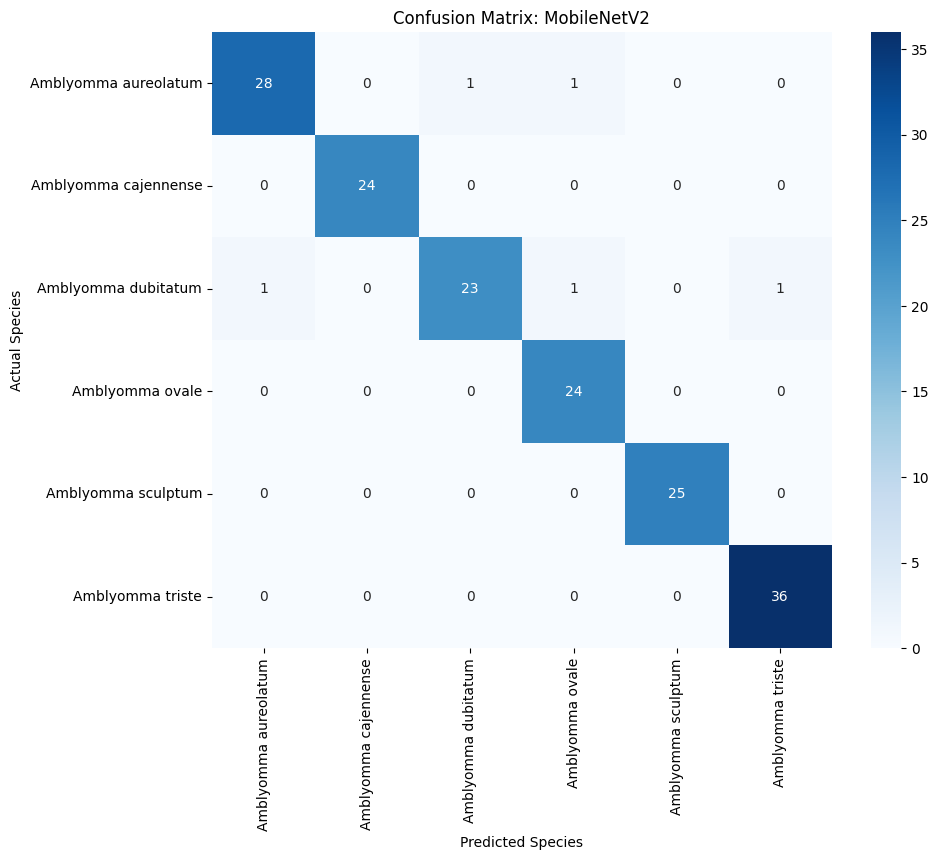

In [ ]:
def plot_cm(y_true, y_pred, class_names, model_title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix: {model_title}')
    plt.ylabel('Actual Species')
    plt.xlabel('Predicted Species')
    plt.show()

plot_cm(y_true, y_pred, species_labels, "MobileNetV2")

| Architecture   | Final Accuracy | Primary Metric Strength                                  |
|----------------|----------------|----------------------------------------------------------|
| ResNet-50      | 93.94%         | Strong stability across all 50 epochs                    |
| AlexNet        | 93.33%         | Efficient feature extraction for large physical traits   |
| MobileNetV2    | 95.15%         | Best overall performance and highest sensitivity         |


##Parameters and Hyperparameters

To maintain consistency with the study by Gomes et al. (2025), we utilize a standardized set of hyperparameters across all three architectures. This ensures that the performance comparison is fair and based on the structural differences of the models rather than different tuning settings.

- Epochs (50): Provides sufficient iterations for the model weights to converge.

- Batch Size (64): Chosen to balance computational efficiency on the T4 GPU and gradient stability.

- Learning Rate (0.001): A standard starting point for transfer learning to prevent large weight updates that could destroy pre-trained features.

- Optimizers: > * Adam is used for ResNet-50 and MobileNetV2 for its adaptive learning rate capabilities.

- SGDM (Momentum=0.9) is used for AlexNet as specified in the base paper to improve generalization.

## Inference
Based on the training and evaluation results, we can draw several key conclusions:

- MobileNetV2 Efficiency: MobileNetV2 outperformed both ResNet-50 and AlexNet with an accuracy of 95.15%. This suggests that its Inverted Residual Blocks are highly effective at identifying the specific biological markers (dorsal shield patterns) of these ticks, even with a relatively small dataset.

- Model Depth vs. Accuracy: Interestingly, the 50-layer ResNet did not significantly outperform the 8-layer AlexNet. This indicates that for specialized biological identification tasks, a moderate number of layers is sufficient if the pre-trained weights (from ImageNet) are well-utilized.

- Potential for Field Use: Because MobileNetV2 is lightweight and achieved the highest accuracy, it is the most suitable model for integration into a mobile application. Such a tool would allow health professionals to identify spotted-fever vectors instantly in the field without needing a supercomputer.

- Species Similarity: The confusion matrices indicate that species within the same complex (like A. sculptum and A. cajennense) are the most common sources of error due to their high morphological similarity

##Reference
1. Gomes, M. G., et al. (2025). Automated identification of spotted-fever tick vectors using convolutional neural networks.
2. Tick ​​images from "Automated identification of spotted-fever tick vectors using convolutional neural networks" (under review, Medical and Veterinary Entomology, Wiley; print ISSN: 0269-283X; online ISSN: 1365-2915